In [439]:
import pandas as pd
import numpy as np
import sqlite3
import re

conn = sqlite3.connect("profiles.db")
cursor = conn.cursor()
cursor.execute("ATTACH DATABASE 'colleges.db' AS colleges")

In [440]:
df = pd.read_sql_query("SELECT * FROM colleges.university_profiles AS c JOIN profiles AS p ON c.school = p.school",conn)
df_w_admission_rate = df.copy(deep=True)

In [441]:
def get_type_map(df_column):
    return {t:i for i, t in enumerate(set(df_column))}

def convert_sat_to_act(sat):
    if np.isnan(sat):
        return np.nan
    sat_scores = np.array([990, 1060, 1140, 1210, 1270, 1330, 1390, 1450, 1510, 1560, 1620, 1680, 1740, 1800, 1860, 1920, 1980, 2020, 2080, 2140, 2220, 2290, 2380, 2410])
    return np.where(sat < sat_scores)[0][0] + 13
    
def combine_test_scores(x):
    if not np.isnan(x['act']):
        return x['act']/36.0
    sat = np.array([x['sat_m'], x['sat_r'], x['sat_w']])
    return convert_sat_to_act(3*sat[~np.isnan(sat)].mean())/36.0 if len(sat[np.isnan(sat)]) != 3 else np.nan

def convert_string(x):
    try:
        return int(x)
    except:
        return np.nan

def combine_avg_test_scores(x):
    if not np.isnan(convert_string(x['avg_act'])):
        return convert_string(x['avg_act'])/36.0
    sat = np.array([convert_string(x['sat_math']), convert_string(x['sat_reading']), convert_string(x['sat_writing'])])
    return convert_sat_to_act(3*sat[~np.isnan(sat)].mean())/36.0 if len(sat[np.isnan(sat)]) != 3 else np.nan

def map_statuses(x):
    status_map = {"Denied": 0, "Deferred": 0, "Wait-Listed": 0, "Accepted": 2, "Will Attend": 2}
    return status_map[x['status']]

def convert_class_rank(x):
    s = str(x['class_rank'])
    if " of " in s:
        return float(s[:s.index(" of ")])/float(s[s.index(" of ") + 4:])
    if "Top " in s:
        return float(s[4:s.index("%")])/100.0
    if "Bottom " in s:
        return float(s[7:s.index("%")])/100.0
    return np.nan

def convert_instate_tuition(x):
    if "<br>" in str(x['cost_attendance']):
        instate = x['cost_attendance'].split("<br>")[0]
        return instate[instate.index("$")+1:]
    else:
        return x['cost_attendance']

def convert_outstate_tuition(x):
    if "<br>" in str(x['cost_attendance']):
        outstate = x['cost_attendance'].split("<br>")[1]
        return outstate[outstate.index("$")+1:]
    else:
        return x['cost_attendance']

def get_tuition(x):
    return x['in_state_tuition'] if x['state'] == x['hs_state'] else x['out_state_tuition']

def map_hs_types(x):
    hs_type_map = {"Public": 0, "Private": 1, "Parochial": 2, "Home": 3}
    return hs_type_map[x['hs_type']]

def map_ins_types(x):
    ins_type_map = {"Public": 0, "Private": 1, "Private for-profit": 1, "&nbsp;": np.nan}
    return ins_type_map[x['institution_type']]

In [442]:
df = df.loc[:,~df.columns.duplicated()]
df.fillna(value=pd.np.nan, inplace=True)
df['avg_act'] = df['avg_act'].map(lambda x: str(x).strip('-'))
df['test_score'] = df.apply(combine_test_scores, axis=1)
df['avg_test_score'] = df.apply(combine_avg_test_scores, axis=1)
df['class_rank'] = df.apply(convert_class_rank, axis=1)
df['institution_type'] = df.apply(map_ins_types, axis=1)
df['in_state_tuition'] = df.apply(convert_instate_tuition, axis=1)
df['out_state_tuition'] = df.apply(convert_outstate_tuition, axis=1)
#df['tuition'] = df.apply(get_tuition, axis=1)

for col in ['cost_attendance', 'city', 'sat_m', 'sat_r', 'sat_w', 'act', 'sat_math', 'sat_reading', 'sat_writing', 'avg_act']:
    df = df.drop(col, axis=1)

df = df.dropna()#subset=['test_score','avg_test_score','gpa_uw','class_rank','hs_state','hs_type','institution_type'])

df['status'] = df.apply(map_statuses, axis=1)
df['hs_type'] = df.apply(map_hs_types, axis=1)
replace_columns = ['hs_state', 'state', 'gender']
for col in replace_columns:
    df[col].replace(get_type_map(df[col]), inplace=True)

In [443]:
print(len(df.index))

35768


In [444]:
whole_df = df

def split_df_on(feature=None):
    split_dfs = {}
    if feature:
        for val in whole_df[feature].unique():
            split_dfs[val] = (whole_df.loc[whole_df[feature]==val])
    else:
        split_dfs = {'all': whole_df}
    return split_dfs
df.sample(n=100)



,school,state,avg_gpa,average_freshman_aid,admission_rate,faculty_total,international_percent,institution_type,female_percentage,year,...,gpa_uw,class_rank,status,eaed,legacy,athlete,test_score,avg_test_score,in_state_tuition,out_state_tuition
67404,"University of California, Los Angeles",26,4.36,24405,18,1570,11.,0.0,57.5,2014,...,3.85,0.026667,2,0,0,0,0.805556,0.805556,30485,58499
55227,"University of California, Riverside",26,3.74,26448,57,976,2.9,0.0,54.3,2017,...,3.86,0.129151,2,0,0,0,0.750000,0.666667,36092,64106
1426,Saint Joseph's University,39,3.61,30645,77,308,1.8,1.0,54.4,2019,...,3.00,0.569369,2,1,0,0,0.638889,0.722222,60854,60854
85742,University of North Carolina at Chapel Hill,46,4.67,17732,24,1672,2.7,0.0,58.8,2011,...,3.95,0.045872,0,1,0,0,0.861111,0.833333,23810,49993
87747,Salisbury University,8,3.62,8990,65,435,1.3,0.0,55.9,2018,...,3.23,0.315436,2,0,0,0,0.583333,0.638889,25132,34172
9201,Princeton University,50,3.91,54310,6,959,11.,1.0,48.6,2017,...,3.70,0.093750,0,0,0,0,0.916667,0.861111,66510,66510
42849,"University of California, Irvine",26,3.97,23886,37,1290,16.,0.0,52.7,2012,...,3.40,0.100000,2,0,0,0,0.666667,0.805556,33826,61840
7041,University of Pittsburgh,39,4.14,12960,60,1791,4.1,0.0,51.5,2014,...,3.80,0.099869,2,0,0,0,0.944444,0.805556,33250,44812
12054,Temple University,39,3.54,19406,57,1483,7.0,0.0,52.7,2018,...,4.00,0.021277,2,0,0,0,0.916667,0.750000,32300,44060
63413,University of Miami,1,3.50,46432,36,1115,14.,1.0,52.3,2013,...,3.75,0.094118,2,0,0,0,0.861111,0.833333,66274,66274


In [445]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

split_on = None
for val, df_s in split_df_on(split_on).items():
    k = 1
    
    df0 = df_s[df.status == 0]
    df2 = df_s[df.status == 2].sample(n = int(k*len(df0)))
    
    df_final = pd.concat([df0, df2])
    df_final_copy = df_final.copy()
    X = df_final.drop('status', axis=1)
    y = df_final['status']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_test_copy = X_test.copy()
    schools = X_test['school']
    X_test_copy['status'] = y_test
    
    scaler = StandardScaler()
    scaler.fit(X_train.drop('school', axis=1))
    X_train = scaler.transform(X_train.drop('school', axis=1))
    X_test = scaler.transform(X_test.drop('school', axis=1))

    mlp = MLPClassifier(hidden_layer_sizes=(21, 21, 21),max_iter=1000)
    mlp.fit(X_train,y_train)
    predictions = mlp.predict(X_test)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))

    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    score = logisticRegr.score(X_test, y_test)
    print(f"Logistic Regression Score for {split_on} {val}: " + str(score))



[[1463  324]
 [ 386 1469]]
             precision    recall  f1-score   support

          0       0.79      0.82      0.80      1787
          2       0.82      0.79      0.81      1855

avg / total       0.81      0.81      0.81      3642

Logistic Regression Score for None all: 0.78555738605162


In [446]:
old_x = X_test_copy.copy()
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_test)

In [447]:

from collections import defaultdict
# Experimental Acceptance Rate
e_a_r = defaultdict(lambda: defaultdict(int))
total_applicants = 0
most_inaccurate = defaultdict(lambda: defaultdict(int))
for res, school, (index, row) in zip(mlp.predict(X), schools, old_x.iterrows()):
    if res == 0:
        e_a_r[school]['experimental_reject'] += 1
    elif res == 2:
        e_a_r[school]['experimental_accept'] += 1
    if res != row['status']:
        
        #print(f'predicted {"accept" if res==2 else "reject"} was actually {"accept" if row["status"] ==2 else "reject"}')
        #print(school)
        #print(row['avg_gpa'], row['avg_test_score'], row['gpa_w'], row['test_score'])
        if res == 2 and row['status'] == 0:
            most_inaccurate[school]['wrong_accept'] += 1
        else:
            most_inaccurate[school]['wrong_reject'] += 1
        most_inaccurate[school]['total_wrong'] += 1
    e_a_r[school]['total'] += 1
    total_applicants += 1

print(most_inaccurate)

for school in schools.unique():
    for student in df_final_copy[df_final_copy['school'] == school].iterrows():
        if student[1][16] == 0:
            e_a_r[school]['observed_reject'] += 1
        else:
            e_a_r[school]['observed_accept'] += 1

print(total_applicants == len(schools))


defaultdict(<function <lambda> at 0x0000018EC8788488>, {'University of California, Berkeley': defaultdict(<class 'int'>, {'wrong_reject': 21, 'total_wrong': 26, 'wrong_accept': 5}), 'East Carolina University': defaultdict(<class 'int'>, {'wrong_reject': 4, 'total_wrong': 5, 'wrong_accept': 1}), 'University of Chicago': defaultdict(<class 'int'>, {'wrong_reject': 11, 'total_wrong': 12, 'wrong_accept': 1}), 'Elon University': defaultdict(<class 'int'>, {'wrong_accept': 6, 'total_wrong': 6}), 'California State University Monterey Bay': defaultdict(<class 'int'>, {'wrong_reject': 2, 'total_wrong': 2}), 'Florida State University': defaultdict(<class 'int'>, {'wrong_reject': 4, 'total_wrong': 11, 'wrong_accept': 7}), 'University of Alabama': defaultdict(<class 'int'>, {'wrong_reject': 3, 'total_wrong': 3}), 'Boston University': defaultdict(<class 'int'>, {'wrong_accept': 2, 'total_wrong': 7, 'wrong_reject': 5}), 'University of North Carolina at Chapel Hill': defaultdict(<class 'int'>, {'wron

True


In [448]:
e_a_r

defaultdict(<function __main__.<lambda>>,
            {'Adams State University': defaultdict(int,
                         {'experimental_accept': 1,
                          'observed_reject': 1,
                          'total': 1}),
             'Adelphi University': defaultdict(int,
                         {'experimental_accept': 3,
                          'observed_accept': 17,
                          'total': 3}),
             'Agnes Scott College': defaultdict(int,
                         {'experimental_accept': 2,
                          'observed_accept': 6,
                          'observed_reject': 1,
                          'total': 2}),
             'Alabama State University': defaultdict(int,
                         {'experimental_accept': 1,
                          'observed_accept': 4,
                          'observed_reject': 2,
                          'total': 1}),
             'Albany State University': defaultdict(int,
                         

In [449]:
compare_vs_ground_truth = defaultdict(str)

for (index, row), school in zip(old_x.iterrows(), schools):
    accept_rate = None
    if e_a_r[school]['experimental_accept'] != 0 and e_a_r[school]['experimental_reject'] != 0:
        accept_rate = e_a_r[school]['experimental_accept']/e_a_r[school]['total']
    elif e_a_r[school]['experimental_accept'] == 0:
        accept_rate = 0
    elif e_a_r[school]['experimental_reject'] == 0:
        accept_rate = 1
    actual_accept_rate = None
    if e_a_r[school]['observed_accept'] != 0 and e_a_r[school]['observed_reject'] != 0:
        actual_accept_rate = e_a_r[school]['observed_accept']/(e_a_r[school]['observed_reject'] + e_a_r[school]['observed_accept'])
    elif e_a_r[school]['observed_accept'] == 0:
        actual_accept_rate = 0
    elif e_a_r[school]['observed_reject'] == 0:
        actual_accept_rate = 1
    compare_vs_ground_truth[school] = [accept_rate, actual_accept_rate, int(row['admission_rate'])/100]

In [450]:
compare_vs_ground_truth

defaultdict(str,
            {'Adams State University': [1, 0, 0.99],
             'Adelphi University': [1, 1, 0.73],
             'Agnes Scott College': [1, 0.8571428571428571, 0.66],
             'Alabama State University': [1, 0.6666666666666666, 0.98],
             'Albany State University': [1, 0.4, 0.5],
             'Albion College': [1, 1, 0.71],
             'Albright College': [1, 1, 0.5],
             'Alcorn State University': [1, 1, 0.79],
             'Alfred University': [0.6666666666666666, 0.8, 0.63],
             'Allegheny College': [1, 0.7142857142857143, 0.68],
             'Alma College': [1, 1, 0.64],
             'Alvernia University': [1, 1, 0.74],
             'American University': [0.5714285714285714,
              0.5274725274725275,
              0.29],
             'Anderson University': [1, 0.7777777777777778, 0.65],
             'Appalachian State University': [0.4166666666666667,
              0.6111111111111112,
              0.7],
             'Arca

In [451]:
avg_error = 0
error_rates = {}
for (school, admission_stats), (school_2, comparisons) in zip(e_a_r.items(), compare_vs_ground_truth.items()):
    if admission_stats['total'] > 25:
        if school != school_2:
            print("there's a huge mistake somewhere")
        error = abs(comparisons[1]-comparisons[0])
        weight_error = admission_stats['total']/total_applicants
        avg_error += error*weight_error
        error_rates[school] = {'error': error, 'experimental_rate': comparisons[0], 'observed_rate': comparisons[1], 'university_reported': comparisons[2]}
        error_rates[school].update(admission_stats)

In [452]:
avg_error

0.03908268185343031

In [453]:
sorted_errors = sorted(error_rates.items(), reverse=False, key=lambda item: item[1]['error'])
flatten_dict = []
for school, stats in sorted_errors:
    stats['school'] = school
    flatten_dict.append(stats)
flatten_dict

[{'error': 0.0018583042973286945,
  'experimental_accept': 16,
  'experimental_rate': 0.45714285714285713,
  'experimental_reject': 19,
  'observed_accept': 56,
  'observed_rate': 0.45528455284552843,
  'observed_reject': 67,
  'school': 'Emory University',
  'total': 35,
  'university_reported': 0.22},
 {'error': 0.0026155187445510153,
  'experimental_accept': 15,
  'experimental_rate': 0.4838709677419355,
  'experimental_reject': 16,
  'observed_accept': 72,
  'observed_rate': 0.4864864864864865,
  'observed_reject': 76,
  'school': 'Fordham University',
  'total': 31,
  'university_reported': 0.46},
 {'error': 0.008958837772397032,
  'experimental_accept': 19,
  'experimental_rate': 0.5428571428571428,
  'experimental_reject': 16,
  'observed_accept': 63,
  'observed_rate': 0.5338983050847458,
  'observed_reject': 55,
  'school': 'University of Central Florida',
  'total': 35,
  'university_reported': 0.5},
 {'error': 0.013871374527112179,
  'experimental_accept': 12,
  'experimenta

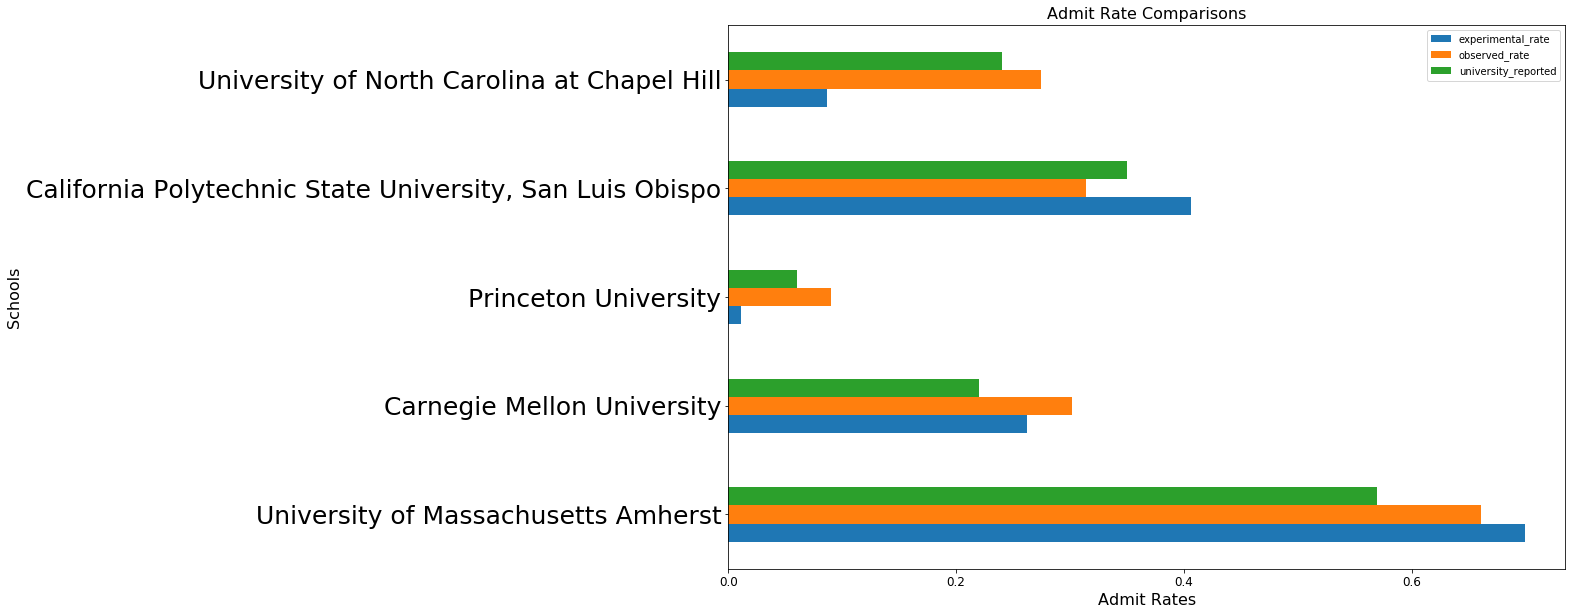

In [550]:
import matplotlib.pyplot as plt
import matplotlib
output_df = pd.DataFrame(flatten_dict, columns=['school', 'error', 'experimental_rate', 'observed_rate', 'university_reported', 'experimental_accept', 'experimental_reject', 'observed_accept', 'observed_reject'])
graph_me = output_df.sample(5).sort_values(by=['error'])
graph_me
#output_df
graph_me.set_index("school",drop=True,inplace=True)
ax = graph_me[['experimental_rate', 'observed_rate', 'university_reported']].plot(kind='barh', figsize=(15, 10), legend=True, fontsize=12)
plt.yticks(fontsize=25)
ax.set_xlabel("Admit Rates", fontsize=16)

ax.set_ylabel("Schools", fontsize=16)
ax.set_title("Admit Rate Comparisons", fontsize=16)
plt.show()


In [455]:
graph_me

,error,experimental_rate,observed_rate,university_reported,experimental_accept,experimental_reject,observed_accept,observed_reject
school,,,,,,,,
University of Central Florida,0.008959,0.542857,0.533898,0.50,19,16,63,55
Tulane University,0.017102,0.395833,0.412935,0.21,19,29,83,118
Stanford University,0.039808,0.021898,0.061706,0.05,3,134,34,517
Boston University,0.049290,0.344828,0.394118,0.25,10,19,67,103
Penn State University Park,0.089859,0.764706,0.674847,0.50,26,8,110,53


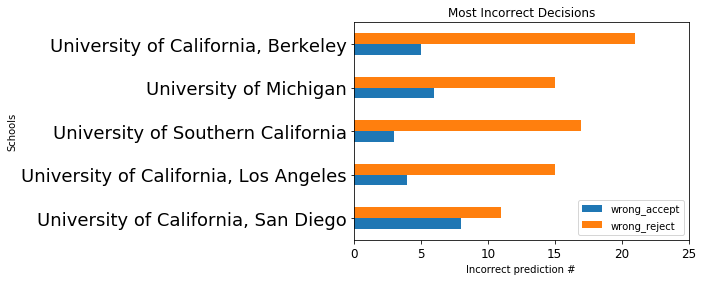

In [561]:
m_i_df = pd.DataFrame(most_inaccurate)
m_i_df = m_i_df.fillna(0)
m_i_df = m_i_df.transpose()
m_i_df = m_i_df.sort_values(by=['total_wrong']).tail()
af = m_i_df[['wrong_accept', 'wrong_reject']].plot(kind='barh')
af.set_title("Most Incorrect Decisions")
af.set_xlabel("Incorrect prediction #")
af.set_ylabel("Schools")
plt.yticks(fontsize=18)
plt.xticks(fontsize=12)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.show()